# Building reproducable pipeline for classification on the example of the Mars Rotation task

## Intro 👋

**Hello!**    
This notebook is my solution for one of the AI Blitz tasks - Rover Classification.
  
So what we gonna do today? Here is the plan:
1. Learn a bunch of tricks for boosting score on the example of my solution
2. Learn how to use AI Crowd API
3. Learn how to get data
4. Learn how to merge datasets
5. Meet K-fold Cross Validation
6. Learn how to use config to configure the entire training
7. Build advanced pipeline for training
8. Build inference

Use the "table of contents" button to quickly navigate through the notebook.



## Problem ❓

The problem that we're solving is [Rover Classification](https://www.aicrowd.com/challenges/ai-blitz-7/problems/rover-classification), one of the [AI Blitz #7](https://www.aicrowd.com/challenges/ai-blitz-7) tasks. It's a Computer Vision Classification task. Our goal is to classify different rovers. We have 2 classes, so it's binary classification task.

## Solution 💡

Before we start writing code, I wanna describe my solution. I will outline the main highlights, and you can find more detailed settings in the config.

* model - Mobile Net V2
* optimizer - Ranger
* learning rate - 0.003
* epoch - 30
* warm up epochs - 3
* early stopping - 8 
* Loss Function - Cross Entropy Loss
* Image size - 256
* pretrained - True
* Frozen BatchNorm layers
* scheduler - CosineBatchDecayScheduler with gradual warm up (custom impelementation)
* mixed precision training (using native pytorch apex)
* gradient accumulation (iters_to_accumulate=8)
* batchsize - 64
* Augmentations: RandomBrightnessContrast, HueSaturationValue, Blur, Rotate, HorizontalFlip, VerticalFlip
* augmentations are turned off during the warm up




## Installations 🌐

### Authorization 

First, we need to log in to the AI Crowd system. We will need this to get the data and make a submission.

In [ ]:
from IPython.display import clear_output
import sys

In [ ]:
!pip install aicrowd-cli==0.1
clear_output(wait=True)
print('Done!')

Done!


In [ ]:
API_KEY = ""  # Please enter your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


### Getting the data

Time to get the data.

In [ ]:
!aicrowd dataset download --challenge rover-classification

!rm -rf data
!mkdir data

!unzip -q train.zip  -d data/train
!unzip -q val.zip -d data/val
!unzip -q test.zip  -d data/test

!mv train.csv data/train.csv
!mv val.csv data/val.csv
!mv sample_submission.csv data/sample_submission.csv

clear_output(wait=True)
print('Done!')

Done!


Before we train the model, let's take a look at the data.

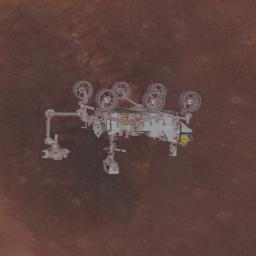

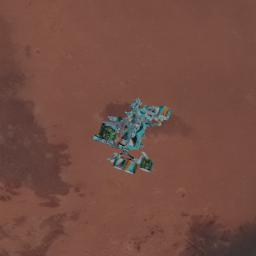

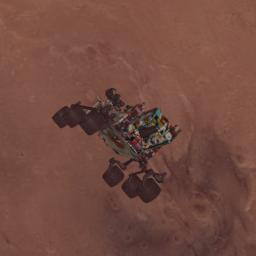

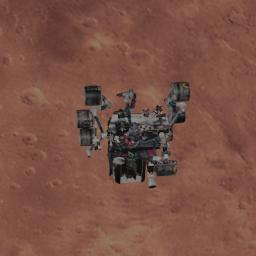

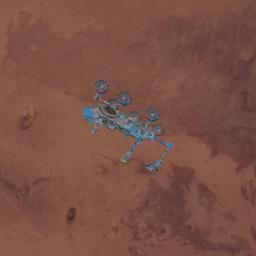

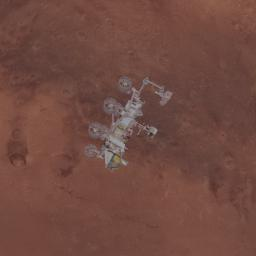

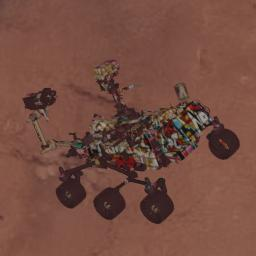

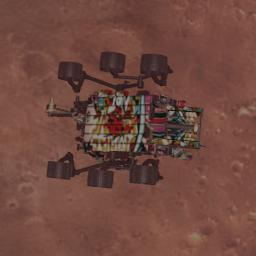

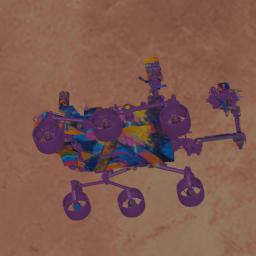

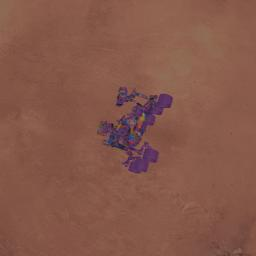

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow

PATH = "/content/data/train"
filenames = os.listdir(PATH)[:10]  # We'll check the first ten images

for filename in filenames:
    print()
    img = cv2.imread(os.path.join(PATH, filename))
    cv2_imshow(img)

### Merging datasets



Our data is pre-divided into a training and validation sample, this is quite convenient, but to get more accurate validation and high accuracy, I'm gonna use K-fold cross validation, for this we need to merge these two datasets into one to get a complete one. We'll do it in three steps: (1) renaming all the files in the validation dataset, (2) moving them into the training dataset, (3) merging csv-files.

This is not the most difficult task, so K-fold doesn't really matter here. However, I just wanna share code for this here to allow you use it in harder tasks in the future, because usually it's really hard to win competition without it. You can read more about it [here](https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85).

In [ ]:
# STEP 1

import os
from tqdm.notebook import tqdm

train_length = len(os.listdir("/content/data/train"))
for i in tqdm(range(len(os.listdir("/content/data/val")))):
    os.rename(f"/content/data/val/{i}.jpg", f"/content/data/val/{i+train_length}.jpg")

In [ ]:
# STEP 2

!git clone https://github.com/t0efL/Dataset-Fixer
!pip install -r /content/Dataset-Fixer/requirements.txt
sys.path.append("/content/Dataset-Fixer")

clear_output(wait=True)
print('Done!')

Done!


In [ ]:
from dataset_fixer import folder_unpacker
folder_unpacker("/content/data/val", "/content/data/train")  # Instant copy

100%|██████████| 4000/4000 [00:00<00:00, 7271.12it/s]


In [ ]:
# STEP 3

import pandas as pd

train = pd.read_csv("/content/data/train.csv")
val = pd.read_csv("/content/data/val.csv")

val["ImageID"] = [int(i) + train_length for i in val["ImageID"].values]
train = pd.concat([train, val], ignore_index=True)
train.to_csv("/content/data/train.csv")

## Set up 🔨

### Config

The main feature of this pipeline is reproducibility. You don't have to change code every time you're gonna test a new approach since you can set up everything you need through the config.

You can easily add new augmentations, loss functions, schedulers and optimizers in config to use them during the training. Moreover you can create custom ones by starting its name in the config from "/custom/" and creating fuction or class with the same name which returns an augmentation or just representing loss fucntion, scheduler or optimizer and takes parameters if needed. By custom functions, I mean those that are not in the pytorch library, and that I have to declare as global variables. 


In [ ]:
class cfg:
    """Main config."""

    seed = 0xFACED    # RANDOM SEED
    NUMCLASSES = 2  # CONST

    # MAIN SETTINGS
    experiment_name = "experiment"   # Name of the current approach
    debug = False                    # Debug flag. If set to True,
                                     # the number of samples will be decreased for faster experiments.
    path_to_imgs = "/content/data/train"     # Path to folder with train images
    path_to_csv = "/content/data/train.csv"  # Path to csv-file with targets
    path = "PATH"                    # Working directory,
                                     # the place where the logs and the weigths will be saved
    log = "log.txt"                  # If exists, all the logs will be saved in this txt-file as well
    chk = ""                         # Path to model checkpoint (weights).
                                     # If exists, the model will be uploaded from this checkpoint.
    device = "cuda"                  # Device

    # MODEL'S SETTINGS
    model_name = "/torch/mobilenet_v2"  # PyTorch (/torch/) or timm (/timm/) model's name
    pretrained = True              # Pretrained flag

    # TRAINING SETTINGS
    num_epochs = 30        # Number of epochs (including warm-up ones)
    warmup_epochs = 3      # Number of warm-up epochs
    train_batchsize = 128  # Train Batch Size
    train_shuffle = True   # Shuffle during training
    val_batchsize = 128    # Validation Batch Size
    val_shuffle = False    # Shuffle during validation
    test_batchsize = 128   # Test Batch Size
    test_shuffle = False   # Shuffle during testing
    num_workers = 4        # Number of workers (dataloader parameter)
    verbose = True         # If set to True, draws plots of loss changes and validation metric changes.
    early_stopping = 8     # Interrupts training after a certain number of epochs if the metrics stops increasing,
                           # set the value to "-1" if you want to turn off this option.
    savestep = 5           # Number of epochs in loop before saving model.
                           # Example: 10 means that weights will be saved each 10 epochs.
    freeze_bn_layers = True  # Freezing BatchNorm Layers flag

    # VALIDATION STRATEGY SETTINGS
    kfold = True   # Uses Startified K-fold validation strategy if turned on. 
                   # Otherwise, simple train-test split will be used.
    n_splits = 5   # Number of splits for Stratified K-fold
    fold = 1       # Number of fold to train
    train_size, val_size, test_size = 0.8, 0.2, 0.0  # Sizes for train-test split.
                                                     # You can set 0.0 value for testsize,
                                                     # in this case test won't be used.

    # APEX PARAMETERS
    mixed_precision = True         # Mixed precision training flag
    gradient_accumulation = True   # Gradient accumulation flag
    iters_to_accumulate = 8        # Parameter for gradient accumulation

    # TRANSFORMS AND AUGMENTATIONS SETTINGS

    # Progressive resize parameters
    start_size = 256  # Start size for progressive resize
    final_size = 256  # Maximum size for progressive resize
    size_step = 32    # Number to increase image size on each epoch
    # Set the same values for start_size and final_size if you wan't to turn of progressive resize.

    pretransforms = [  # Pre-transforms
        dict(
            name="Resize",
            params=dict(
                height=256,
                width=256,
                p=1.0,
            )
        ),
    ]

    augmentations = [    # Augmentations
        dict(
            name="HorizontalFlip",
            params=dict(
                p=0.5,
            )
        ),
        dict(
            name="VerticalFlip",
            params=dict(
                p=0.5,
            )
        ),
        dict(
            name="Rotate",
            params=dict(
                limit=[-180, 180],
                p=0.5,
            )
        ),
        dict(
            name="RandomBrightnessContrast",
            params=dict(
                brightness_limit=0.1,
                contrast_limit=0.15,
                p=0.5, 
            )
        ),
        dict(
            name="HueSaturationValue",
            params=dict( 
                hue_shift_limit=20,
                sat_shift_limit=30,
                val_shift_limit=20,
                p=0.5,
            )
        ),
        dict(
            name="Blur",
            params=dict( 
                blur_limit=2.5,
                p=0.5,
            )
        ),
    ]

    posttransforms = [  # Post-transforms
        dict(
            name="Normalize",
            params=dict(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
            )
        ),
        dict(
            name="/custom/totensor",
            params=dict(
            )
        ),
    ]

    # OPTIMIZER SETTINGS
    optimizer = "/custom/Ranger"  # PyTorch optimizer or custom one
    optimizer_params = dict(
        lr=0.00003,  # Learning rate
    )

    # SCHEDULER SETTINGS
    scheduler = "/custom/CosineBatchDecayScheduler" # PyTorch scheduler or custom one
    scheduler_params = dict(
        epochs=120,
        steps=44000 * 110 / train_batchsize,
        batchsize=train_batchsize,
        decay=32,
        startepoch=4,
        minlr=1e-8,
    )


    # LOSS FUNCTIONS SETTINGS
    lossfn = "CrossEntropyLoss"  # PyTorch loss fucntion or custom one
    lossfn_params = dict(
    )

    # DON'T CHANGE
    # Can be changed only with uploading the model from the checkpoint.
    stopflag = 0
    scheduler_state = None
    optim_dict = None
    epoch = 0

### Installations

In [ ]:
!pip uninstall albumentations --yes
!pip install albumentations

!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
sys.path.append("/content/Ranger-Deep-Learning-Optimizer")

!pip install timm

clear_output(wait=True)
print('Done!')

Done!


### Imports

In [ ]:
import random
import os
import gc
import cv2
import time
import math

import timm
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensor

import torch
import torch.nn as nn
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from torch.cuda import amp
from torchvision import models
import torch.optim as optim

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, KFold 

from warmup_scheduler import GradualWarmupScheduler
from ranger.ranger import Ranger

import warnings
warnings.filterwarnings("ignore")

### Reproducibility

In [ ]:
def fullseed(seed=0xFACED):
    """Sets the random seeds."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    os.environ['PYTHONHASHSEED'] = str(seed)

    
fullseed(cfg.seed)

### Checking device

In [ ]:
assert torch.cuda.is_available() or not cfg.device == "cuda", "cuda isn't available"
device = torch.device(cfg.device)
print("Device:", device)

Device: cuda


## Initializing functions 💻

### Custom fucntions and classes

In [ ]:
def totensor():
    """An example of custom transform function."""
    return A.pytorch.ToTensor()

In [ ]:
class CosineBatchDecayScheduler(_LRScheduler):
    """
    Custom scheduler with calculating learning rate according batchsize
    based on Cosine Decay scheduler. Designed to use scheduler.step() every batch.
    """

    def __init__(self, optimizer, steps, epochs, batchsize=128, decay=128, startepoch=1, minlr=1e-8, last_epoch=-1):
        """
        Args:
            optimizer (torch.optim.Optimizer): PyTorch Optimizer
            steps (int): total number of steps
            epochs (int): total number of epochs
            batchsize (int): current training batchsize. Default: 128
            decay (int): batchsize based on which the learning rate will be calculated. Default: 128
            startepoch (int): number of epoch when the scheduler turns on. Default: 1
            minlr (float): the lower threshold of learning rate. Default: 1e-8
            last_epoch (int): The index of last epoch. Default: -1.
        """
        decay = decay * math.sqrt(batchsize)
        self.stepsize = batchsize / decay
        self.startstep = steps / epochs * (startepoch - 1) * self.stepsize
        self.minlr = minlr
        self.steps = steps
        self.stepnum = 0
        super(CosineBatchDecayScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        """Formula for calculating the learning rate."""
        self.stepnum += self.stepsize
        if self.stepnum < self.startstep:
            return [baselr for baselr in self.base_lrs]
        return [max(self.minlr, 1/2 * (1 + math.cos(self.stepnum * math.pi / self.steps)) * self.optimizer.param_groups[0]['lr']) for t in range(len(self.base_lrs))]


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in
                    self.base_lrs]


### Utils

In [ ]:
def get_model(cfg):
    """Get PyTorch model."""
    if cfg.chk:  # Loading model from the checkpoint
        print("Model:", cfg.model_name)
        if cfg.model_name.startswith("/timm/"):
            model = timm.create_model(cfg.model_name[6:], pretrained=False)
        elif cfg.model_name.startswith("/torch/"):
            model = getattr(models, cfg.model_name[7:])(pretrained=False)
        else:
            raise RuntimeError("Unknown model source. Use /timm/ or /torch/.")
        # Changing the last layer according the number of classes
        lastlayer = list(model._modules)[-1]
        try:
            setattr(model, lastlayer, nn.Linear(in_features=getattr(model, lastlayer).in_features,
                                                out_features=cfg.NUMCLASSES, bias=True))
        except AttributeError:
            setattr(model, lastlayer, nn.Linear(in_features=getattr(model, lastlayer)[1].in_features,
                                                out_features=cfg.NUMCLASSES, bias=True))
        cp = torch.load(cfg.chk)
        epoch, trainloss, valloss, metric, lr, stopflag = None, None, None, None, None, None
        if 'model' in cp:
            model.load_state_dict(cp['model'])
        else:
            model.load_state_dict(cp)
        if 'epoch' in cp:
            epoch = int(cp['epoch'])
            cfg.epoch = epoch
            cfg.warmup_epochs = max(1, cfg.warmup_epochs - epoch)
        if 'trainloss' in cp:
            trainloss = cp['trainloss']
        if 'valloss' in cp:
            valloss = cp['valloss']
        if 'metric' in cp:
            metric = cp['metric']
        if 'optimizer' in cp:
            cfg.optim_dict = cp['optimizer']
            lr = cp['optimizer']["param_groups"][0]['lr']
        if 'stopflag' in cp:
            stopflag = cp['stopflag']
            cfg.stopflag = stopflag
        if 'scheduler' in cp:
            cfg.scheduler_state = cp['scheduler']
        if 'size' in cp:
            cfg.start_size = cp['size']
        print("Uploading model from the checkpoint...",
              "\nEpoch:", epoch,
              "\nTrain Loss:", trainloss,
              "\nVal Loss:", valloss,
              "\nMetrics:", metric,
              "\nlr:", lr,
              "\nstopflag:", stopflag)
        
    else:  # Creating a new model
        print("Model:", cfg.model_name)
        if cfg.model_name.startswith("/timm/"):
            model = timm.create_model(cfg.model_name[6:], pretrained=cfg.pretrained)
        elif cfg.model_name.startswith("/torch/"):
            model = getattr(models, cfg.model_name[7:])(pretrained=cfg.pretrained)
        else:
            raise RuntimeError("Unknown model source. Use /timm/ or /torch/.")
        # Changing the last layer according the number of classes
        lastlayer = list(model._modules)[-1]
        try:
            setattr(model, lastlayer, nn.Linear(in_features=getattr(model, lastlayer).in_features,
                                                out_features=cfg.NUMCLASSES, bias=True))
        except AttributeError:
            setattr(model, lastlayer, nn.Linear(in_features=getattr(model, lastlayer)[1].in_features,
                                                out_features=cfg.NUMCLASSES, bias=True))
    return model.to(cfg.device)


def get_optimizer(model, cfg):
    "Get PyTorch optimizer."
    optimizer = globals()[cfg.optimizer[8:]](model.parameters(), **cfg.optimizer_params) \
        if cfg.optimizer.startswith("/custom/") \
        else getattr(optim, cfg.optimizer)(model.parameters(), **cfg.optimizer_params)
    if cfg.optim_dict:
        optimizer.load_state_dict(cfg.optim_dict)
    return optimizer


def get_scheduler(optimizer, cfg):
    """Get PyTorch scheduler."""
    afterone = globals()[cfg.scheduler[8:]](optimizer, **cfg.scheduler_params) \
        if cfg.scheduler.startswith("/custom/") \
        else getattr(optim.lr_scheduler, cfg.scheduler)(optimizer, **cfg.scheduler_params)
    scheduler = GradualWarmupSchedulerV2(optimizer, multiplier=100, total_epoch=cfg.warmup_epochs, after_scheduler=afterone)
    if cfg.scheduler_state:
        scheduler.load_state_dict(cfg.scheduler_state)
    return scheduler


def get_lossfn(cfg):
    """Get PyTorch loss function."""
    return globals()[cfg.lossfn[8:]](**cfg.lossfn_params) \
        if cfg.lossfn.startswith("/custom/") \
        else getattr(nn, cfg.lossfn)(**cfg.lossfn_params)


def get_transforms(cfg):
    """Get train and test augmentations."""
    pretransforms = [globals()[item["name"][8:]](**item["params"]) if item["name"].startswith("/custom/")
                     else getattr(A, item["name"])(**item["params"]) for item in cfg.pretransforms]
    augmentations = [globals()[item["name"][8:]](**item["params"]) if item["name"].startswith("/custom/")
                     else getattr(A, item["name"])(**item["params"]) for item in cfg.augmentations]
    posttransforms = [globals()[item["name"][8:]](**item["params"]) if item["name"].startswith("/custom/")
                      else getattr(A, item["name"])(**item["params"]) for item in cfg.posttransforms]
    train = A.Compose(pretransforms + augmentations + posttransforms)
    test = A.Compose(pretransforms + posttransforms)
    return train, test


def savemodel(model, epoch, trainloss, valloss, metric, optimizer, stopflag, name, scheduler, size):
    """Saves PyTorch model."""
    torch.save({
        'model': model.state_dict(),
        'epoch': epoch,
        'trainloss': trainloss,
        'valloss': valloss,
        'metric': metric,
        'optimizer': optimizer.state_dict(),
        'stopflag': stopflag,
        'scheduler': scheduler.state_dict(),
        'size': size,
    }, name)


def drawplot(trainlosses, vallosses, metrics, lrs):
    """Draws plots of loss changes and test metric changes."""
    # Learning rate changes
    plt.plot(range(len(lrs)), lrs, label='Learning rate')
    plt.legend()
    plt.title("Learning rate changes")
    plt.show()
    # Validation and train loss changes
    plt.plot(range(len(trainlosses)), trainlosses, label='Train Loss')
    plt.plot(range(len(vallosses)), vallosses, label='Val Loss')
    plt.legend()
    plt.title("Validation and train loss changes")
    plt.show()
    # Test metrics changes
    plt.plot(range(len(metrics)), metrics, label='Metrics')
    plt.legend()
    plt.title("Test metrics changes")
    plt.show()


def printreport(t, trainloss, valloss, metric, record):
    """Prints epoch's report."""
    print(f'Time: {t} s')
    print(f'Train Loss: {trainloss:.4f}')
    print(f'Val Loss: {valloss:.4f}')
    print(f'Metrics: {metric:.4f}')
    print(f'Current best metrics: {record:.4f}')


def savelog(path, epoch, trainloss, valloss, metric):
    """Saves the epoch's log."""
    with open(path, "a") as file:
        file.write("epoch: " + str(epoch) + " trainloss: " + str(
            round(trainloss, 5)) + " valloss: " + str(
                round(valloss, 5)) + " metrics: " + str(round(metric, 5)) + "\n")

### Data functions

Here you can notice one interesting moment. I decrease each class value predicted by model on 1 during the training and increase it on 1 during the inference (you'll see it at the end of the notebook). The reason is that labels in csv-file are ranged from 1 to 360, when loss function takes the labels ranged from 0 to n. So I'm training model on [0, ..., 359] classes and making submitting solution which contatins [1, ..., 360] classes. Otherwise it breaks the training or inference.

In [ ]:
def datagenerator(cfg):
    """Generates data (images and targets) for train and test."""

    print("Getting the data...")
    assert cfg.train_size + cfg.val_size + cfg.test_size == 1, "the sum of the split size must be equal to 1."
    data = pd.read_csv(cfg.path_to_csv)
    if cfg.debug:
        data = data.sample(n=1000, random_state=cfg.seed).reset_index(drop=True)

    # One-hot encoding
    target_mapping = {
        "curiosity": 0,
        "perseverance": 1,
    }
    data["label"] = data["label"].map(target_mapping)

    if not cfg.kfold:
        targets = list(data["label"])
        files = list(data["ImageID"])

        # If test size is equal zero, we split the data only into train and validation parts,
        # otherwise we split it into train, validation and test parts.
        trainimgs, testimgs, traintargets, testtargets = train_test_split(files, targets, train_size=cfg.train_size,
                                                                          test_size=cfg.val_size + cfg.test_size,
                                                                          random_state=cfg.seed, stratify=targets)
    else:
        kf = KFold(n_splits=cfg.n_splits, shuffle=False)
        fold = 1
        for train_index, test_index in kf.split(data):
            if fold == cfg.fold:
                trainimgs = list(data.iloc[train_index]["ImageID"])
                traintargets = list(data.iloc[train_index]["label"])
                testimgs = list(data.iloc[test_index]["ImageID"])
                testtargets = list(data.loc[test_index]["label"])
                break
            fold += 1

    if cfg.test_size == 0:
        return trainimgs, traintargets, testimgs, testtargets

    valimgs, testimgs, valtargets, testtargets = train_test_split(testimgs, testtargets,
                                                                  train_size=cfg.val_size,
                                                                  test_size=cfg.test_size,
                                                                  random_state=cfg.seed,
                                                                  stratify=testtargets)
    
    return trainimgs, traintargets, valimgs, valtargets, testimgs, testtargets


class Dataset(torch.utils.data.Dataset):
    """Dataset for uploading images and targets."""

    def __init__(self, cfg, images, targets, transforms):
        self.images = images  # List with images
        self.targets = targets # List with targets
        self.transforms = transforms  # Transforms
        self.cfg = cfg  # Config

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.cfg.path_to_imgs, str(self.images[idx]) + ".jpg"))
        img = self.transforms(image=img)["image"]
        img = torch.FloatTensor(img)
        target = torch.LongTensor([int(self.targets[idx])])
        return img, target

    def __len__(self):
        return len(self.targets)


def get_loaders(cfg):
    """Getting dataloaders for train, validation (and test, if needed)."""
    trainforms, testforms = get_transforms(cfg)

    # If test size is equal zero, we create the loaders only for train and validation parts,
    # otherwise we create the loaders for train, validation and test parts.
    if cfg.test_size != 0.0:
        trainimgs, traintargets, valimgs, valtargets, testimgs, testtargets = datagenerator(cfg)
        traindataset = Dataset(cfg, trainimgs, traintargets, trainforms)
        valdataset = Dataset(cfg, valimgs, valtargets, testforms)
        testdataset = Dataset(cfg, testimgs, testtargets, testforms)
        trainloader = torch.utils.data.DataLoader(traindataset,
                                                  shuffle=cfg.train_shuffle,
                                                  batch_size=cfg.train_batchsize,
                                                  pin_memory=False,
                                                  num_workers=cfg.num_workers,
                                                  persistent_workers=True)
        valloader = torch.utils.data.DataLoader(valdataset,
                                                shuffle=cfg.val_shuffle,
                                                batch_size=cfg.val_batchsize,
                                                pin_memory=False,
                                                num_workers=cfg.num_workers,
                                                persistent_workers=True)
        testloader = torch.utils.data.DataLoader(testdataset,
                                                 shuffle=cfg.test_shuffle,
                                                 batch_size=cfg.test_batchsize,
                                                 pin_memory=False,
                                                 num_workers=cfg.num_workers,
                                                 persistent_workers=True)
        return trainloader, valloader, testloader

    else:
        trainimgs, traintargets, valimgs, valtargets = datagenerator(cfg)
        traindataset = Dataset(cfg, trainimgs, traintargets, trainforms)
        valdataset = Dataset(cfg, valimgs, valtargets, testforms)
        trainloader = torch.utils.data.DataLoader(traindataset,
                                                  shuffle=cfg.train_shuffle,
                                                  batch_size=cfg.train_batchsize,
                                                  pin_memory=False,
                                                  num_workers=cfg.num_workers,
                                                  persistent_workers=True)
        valloader = torch.utils.data.DataLoader(valdataset,
                                                shuffle=cfg.val_shuffle,
                                                batch_size=cfg.val_batchsize,
                                                pin_memory=False,
                                                num_workers=cfg.num_workers,
                                                persistent_workers=True)
        return trainloader, valloader

### Train functions

In [ ]:
def train(cfg, model, trainloader, optimizer, lossfn, scheduler, epoch, size, scaler):
    """Train loop."""
    print("Training")
    model.train()
    
    # Freezing BatchNorm layers
    if cfg.freeze_bn_layers:
        for name, child in (model.named_children()):
            if name.find('BatchNorm') != -1:
                for param in child.parameters():
                    param.requires_grad = False
            else:
                for param in child.parameters():
                    param.requires_grad = True

    totalloss = 0.0

    for step, batch in enumerate(tqdm(trainloader)):
        inputs, labels = batch
        labels = labels.squeeze(1).to(cfg.device)

        if not cfg.gradient_accumulation:
            optimizer.zero_grad()

        if cfg.mixed_precision:
            with amp.autocast():
                outputs = model(inputs.to(cfg.device).float())
                loss = lossfn(outputs, labels)
                if cfg.gradient_accumulation:
                    loss = loss / cfg.iters_to_accumulate
        else:
            outputs = model(inputs.to(cfg.device).float())
            loss = lossfn(outputs, labels)

        totalloss += loss.item()
        if cfg.mixed_precision:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        if cfg.gradient_accumulation:
            if (step + 1) % cfg.iters_to_accumulate == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        elif cfg.mixed_precision:
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()

        if epoch >= cfg.warmup_epochs + 1:
            scheduler.step()

    if epoch < cfg.warmup_epochs + 1:
        scheduler.step()

    print("Learning rate:", optimizer.param_groups[0]['lr'])
    return totalloss / len(trainloader)


def validation(model, valloader, lossfn, cfg):
    """Validation loop."""
    print("Validating")
    model.eval()
    totalloss = 0.0
    preds, targets = [], []

    with torch.no_grad():
        for batch in tqdm(valloader):
            inputs, labels = batch
            labels = labels.squeeze(1).to(cfg.device)
            outputs = model(inputs.to(cfg.device))
            for idx in np.argmax(outputs.cpu(), axis=1):
                preds.append([1 if idx == i else 0 for i in range(5)])
            for j in labels:
                targets.append([1 if i == j else 0 for i in range(5)])
            loss = lossfn(outputs, labels)
            totalloss += loss.item()

    score = f1_score(targets, preds, average='weighted')
    return totalloss / len(valloader), score


def test(cfg, model, testloader, lossfn):
    """Testing loop."""
    print("Testing")
    model.eval()
    totalloss = 0.0
    preds, targets = [], []

    with torch.no_grad():
        for batch in tqdm(testloader):
            inputs, labels = batch
            labels = labels.squeeze(1).to(cfg.device)
            outputs = model(inputs.to(cfg.device))
            for idx in np.argmax(outputs.cpu(), axis=1):
                preds.append([1 if idx == i else 0 for i in range(5)])
            for j in labels:
                targets.append([1 if i == j else 0 for i in range(5)])
            loss = lossfn(outputs, labels)
            totalloss += loss.item()

    score = f1_score(targets, preds, average='weighted')
    print("Test Loss:", totalloss / len(testloader),
          "\nTest metrics:", score)


def run(cfg):
    """Main function."""

    # Creating working directory
    if not os.path.exists(cfg.path):
        os.makedirs(cfg.path)

    # Getting the objects
    torch.cuda.empty_cache()
    if cfg.test_size != 0.0:
        trainloader, valloader, testloader = get_loaders(cfg)
    else:
        trainloader, valloader = get_loaders(cfg)
    model = get_model(cfg)
    optimizer = get_optimizer(model, cfg)
    if cfg.mixed_precision:
        scaler = amp.GradScaler()
    else:
        scaler = None
    scheduler = get_scheduler(optimizer, cfg)
    lossfn = get_lossfn(cfg)

    # Initializing metrics
    trainlosses, vallosses, metrics, lrs = [], [], [], []
    record = 0
    stopflag = cfg.stopflag if cfg.stopflag else 0
    print('Testing "' + cfg.experiment_name + '" approach.')
    if cfg.log:
        with open(os.path.join(cfg.path, cfg.log), "w") as file:
            file.write('Testing "' + cfg.experiment_name + '" approach.\n')

    # Training
    print("Have a nice training!")
    augs = cfg.augmentations
    size = cfg.start_size  # Image size (Using progressive image size)
    for epoch in range(cfg.epoch + 1, cfg.num_epochs + 1):
        print("\nEpoch:", epoch)

        if size < cfg.final_size and epoch > cfg.warmup_epochs:
            size += cfg.size_step
        if epoch < cfg.warmup_epochs + 1:
            cfg.augmentations = [
            ]
        else:
            cfg.augmentations = augs
        cfg.pretransforms = [
            dict(
                name="Resize",
                params=dict(
                    height=size,
                    width=size,
                    p=1.0,
                )
            ),
        ]
        print("Image size:", size)

        if cfg.test_size != 0.0:
            trainloader, valloader, testloader = get_loaders(cfg)
        else:
            trainloader, valloader = get_loaders(cfg)
        start_time = time.time()

        trainloss = train(cfg, model, trainloader, optimizer, lossfn, scheduler, epoch, size, scaler)
        valloss, metric = validation(model, valloader, lossfn, cfg)
        trainlosses.append(trainloss)
        vallosses.append(valloss)
        metrics.append(metric)
        lrs.append(optimizer.param_groups[0]['lr'])

        if metric > record:
            stopflag = 0
            record = metric
            savemodel(model, epoch, trainloss, valloss, metric,
                      optimizer, stopflag, os.path.join(cfg.path, 'thebest.pt'), scheduler, size)
            print('New record!')
        else:
            stopflag += 1
        if epoch % cfg.savestep == 0:
            savemodel(model, epoch, trainloss, valloss, metric,
                      optimizer, stopflag, os.path.join(cfg.path, f'{epoch}epoch.pt'), scheduler, size)
        t = int(time.time() - start_time)
        printreport(t, trainloss, valloss, metric, record)

        # Saving to the log
        if cfg.log:
            savelog(os.path.join(cfg.path, cfg.log), epoch, trainloss, valloss, metric)

        torch.cuda.empty_cache()
        gc.collect()

        # Early stopping
        if stopflag == cfg.early_stopping:
            print("Training has been interrupted because of early stopping.")
            break
        
        if metric == 1.0:  # You can turn it off
            print("Training has been interrupted  because of achieving max metric value.")
            break

    # Test
    if cfg.test_size != 0.0:
        test(cfg, model, testloader, lossfn)

    # Verbose
    if cfg.verbose:
        drawplot(trainlosses, vallosses, metrics, lrs)

## Training ⚡

Single Fold training

Getting the data...
Model: /torch/mobilenet_v2


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Testing "experiment" approach.
Have a nice training!

Epoch: 1
Image size: 256
Getting the data...
Training



Learning rate: 0.00102
Validating



New record!
Time: 346 s
Train Loss: 0.0858
Val Loss: 0.6672
Metrics: 0.5995
Current best metrics: 0.5995

Epoch: 2
Image size: 256
Getting the data...
Training



Learning rate: 0.00201
Validating



New record!
Time: 341 s
Train Loss: 0.0272
Val Loss: 0.0261
Metrics: 0.9943
Current best metrics: 0.9943

Epoch: 3
Image size: 256
Getting the data...
Training



Learning rate: 0.003
Validating



New record!
Time: 341 s
Train Loss: 0.0014
Val Loss: 0.0031
Metrics: 0.9993
Current best metrics: 0.9993

Epoch: 4
Image size: 256
Getting the data...
Training



Learning rate: 0.003
Validating



Time: 343 s
Train Loss: 0.0031
Val Loss: 0.0038
Metrics: 0.9987
Current best metrics: 0.9993

Epoch: 5
Image size: 256
Getting the data...
Training



Learning rate: 0.003
Validating



Time: 342 s
Train Loss: 0.0008
Val Loss: 0.0025
Metrics: 0.9993
Current best metrics: 0.9993

Epoch: 6
Image size: 256
Getting the data...
Training



Learning rate: 0.003
Validating



New record!
Time: 342 s
Train Loss: 0.0005
Val Loss: 0.0015
Metrics: 0.9997
Current best metrics: 0.9997

Epoch: 7
Image size: 256
Getting the data...
Training



Learning rate: 0.0028958858790332376
Validating



New record!
Time: 343 s
Train Loss: 0.0005
Val Loss: 0.0008
Metrics: 0.9999
Current best metrics: 0.9999

Epoch: 8
Image size: 256
Getting the data...
Training



Learning rate: 0.0026428198881080912
Validating



New record!
Time: 342 s
Train Loss: 0.0004
Val Loss: 0.0009
Metrics: 0.9999
Current best metrics: 0.9999

Epoch: 9
Image size: 256
Getting the data...
Training



Learning rate: 0.002305931890119554
Validating



Time: 342 s
Train Loss: 0.0005
Val Loss: 0.0008
Metrics: 0.9998
Current best metrics: 0.9999

Epoch: 10
Image size: 256
Getting the data...
Training



Learning rate: 0.0019064243545869942
Validating



Time: 342 s
Train Loss: 0.0003
Val Loss: 0.0005
Metrics: 0.9999
Current best metrics: 0.9999

Epoch: 11
Image size: 256
Getting the data...
Training



Learning rate: 0.0014800879239958227
Validating



New record!
Time: 342 s
Train Loss: 0.0003
Val Loss: 0.0003
Metrics: 1.0000
Current best metrics: 1.0000
Training has been interrupted  because of achieving max metric value.


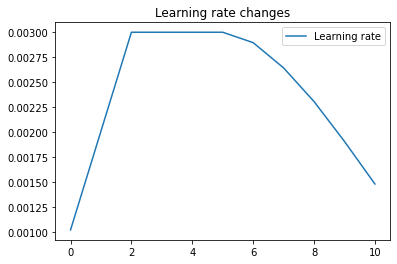

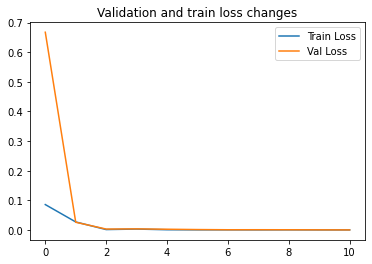

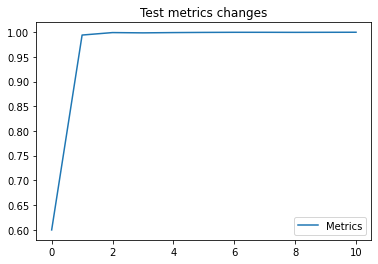

In [ ]:
cfg.fold = 1
cfg.path = "./fold1"
run(cfg)

K-fold training

In [ ]:
# for fold in range(1, 6):
#     print(f"\nFOLD{fold}")
#     cfg.fold = fold
#     cfg.path = f"./fold{fold}"
#     run(cfg)

## Inference 🔦

In [ ]:
PATH_TO_CSV = "/content/data/sample_submission.csv"
PATH_TO_IMGS = "/content/data/test"
DEVICE = cfg.device
MODELNAME = cfg.model_name
NUMCLASSES = cfg.NUMCLASSES

In [ ]:
class Dataset(torch.utils.data.Dataset):
    """Dataset for uploading images and targets."""

    def __init__(self, images, transforms):
        self.images = images  # List with targets
        self.transforms = transforms  # Transforms

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(PATH_TO_IMGS, str(self.images[idx]) + ".jpg"))
        img = self.transforms(image=img)["image"]
        img = torch.FloatTensor(img)
        return img

    def __len__(self):
        return len(self.images)

In [ ]:
transforms = A.Compose([
    A.Resize(height=256,
                width=256,
                p=1.0,),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0),
    A.pytorch.ToTensor(),
])

In [ ]:
df = pd.read_csv(PATH_TO_CSV)
imgs = df["ImageID"].values

In [ ]:
dataset = Dataset(imgs, transforms)
dataloader = torch.utils.data.DataLoader(dataset,
                                        shuffle=False,
                                        batch_size=cfg.test_batchsize,
                                        pin_memory=True,
                                        num_workers=cfg.num_workers)

In [ ]:
if cfg.model_name.startswith("/timm/"):
    model = timm.create_model(cfg.model_name[6:], pretrained=False)
elif cfg.model_name.startswith("/torch/"):
    model = getattr(models, cfg.model_name[7:])(pretrained=False)

lastlayer = list(model._modules)[-1]
try:
    setattr(model, lastlayer, nn.Linear(in_features=getattr(model, lastlayer).in_features,
                                        out_features=NUMCLASSES, bias=True))
except AttributeError:
    setattr(model, lastlayer, nn.Linear(in_features=getattr(model, lastlayer)[1].in_features,
                                        out_features=NUMCLASSES, bias=True))

modellist = []
for fold in range(1, 2): # 1 fold only (USE (1, 6) for 5 folds)
    model.load_state_dict(torch.load(f"/content/fold{fold}/thebest.pt")["model"])
    model.to(DEVICE)
    model.eval()
    modellist.append(model)

set state called


Single Fold inference

In [ ]:
model = modellist[0]
preds = []
model.eval()
with torch.no_grad():
    for img in tqdm(dataloader):
        outputs = model(img.to(DEVICE))
        outputs = (np.argmax(outputs.cpu(), axis=1)).tolist()
        preds += outputs

K-fold inference

In [ ]:
# preds = []
# with torch.no_grad():
#     for img in tqdm(dataloader):
#         outputs = None
#         for model in modellist:
#             output = model(img.to(cfg.device))
#             if outputs is not None:
#                 outputs += output
#             else:
#                 outputs = output
#         preds += (np.argmax(outputs.to('cpu').numpy(), axis=1) + 1).tolist()

## Submission 📩

In [ ]:
target_mapping = {
    0: "curiosity",
    1: "perseverance",
}
df["label"] = preds
df["label"] = df["label"].map(target_mapping)

print(df.head())
df.to_csv("./submission.csv", index=False)

   ImageID         label
0        0  perseverance
1        1  perseverance
2        2     curiosity
3        3  perseverance
4        4  perseverance


It causes error but submits successfully.

In [ ]:
!aicrowd submission create -c rover-classification -f submission.csv
clear_output(wait=True)
print('Done!')

Done!


## Outro 🏁

So that's the end. I hope you found it useful. Now you have even more knowledge and code in your inventory. Feel free to ask any questions. Thanks for reading! All the best! 👋